In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

In [2]:
trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

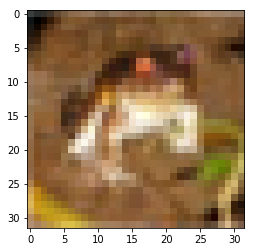

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(trainset[0][0])
plt.show()

In [35]:
def plot_images(images, cls_true, cls_pred=None):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # get its equivalent class name
        cls_true_name = classes[cls_true[i]]
            
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [36]:
# This is an example for the CIFAR-10 dataset.
# There's a function for creating a train and validation iterator.
# There's also a function for creating a test iterator.
# Inspired by https://discuss.pytorch.org/t/feedback-on-pytorch-for-kaggle-competitions/2252/4

def get_train_valid_loader(data_dir,
                           batch_size,
                           augment=False,
                           random_seed=22,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the CIFAR-10 dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # define transforms
    valid_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])
    
    if augment:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                download=False, transform=train_transform)

    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                download=False, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)


    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(train_dataset, 
                                                    batch_size=9, 
                                                    shuffle=shuffle, 
                                                    num_workers=num_workers,
                                                    pin_memory=pin_memory)
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy()
        X = np.transpose(X, [0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)
    
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process 
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    dataset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True,
                               transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers,
                                              pin_memory=pin_memory)

    return data_loader

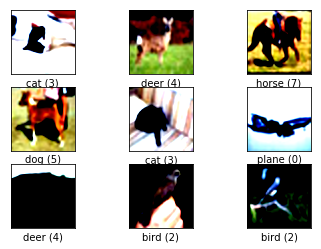

In [46]:
train_loader, validation_loader = get_train_valid_loader('/datasets/CIFAR-10',
                        15,
                        augment=False,
                        random_seed=22,
                        valid_size=0.1,
                        shuffle=True,
                        show_sample=True,
                        num_workers=4,
                        pin_memory=False)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [48]:
from torch.autograd import Variable

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.301
[1,   400] loss: 2.288
[1,   600] loss: 2.244
[1,   800] loss: 2.128
[1,  1000] loss: 2.002
[1,  1200] loss: 1.916
[1,  1400] loss: 1.842
[1,  1600] loss: 1.772
[1,  1800] loss: 1.736
[1,  2000] loss: 1.664
[1,  2200] loss: 1.663
[1,  2400] loss: 1.628
[1,  2600] loss: 1.626
[1,  2800] loss: 1.584
[1,  3000] loss: 1.602
[2,   200] loss: 1.571
[2,   400] loss: 1.543
[2,   600] loss: 1.559
[2,   800] loss: 1.501
[2,  1000] loss: 1.493
[2,  1200] loss: 1.476
[2,  1400] loss: 1.492
[2,  1600] loss: 1.450
[2,  1800] loss: 1.464
[2,  2000] loss: 1.438
[2,  2200] loss: 1.417
[2,  2400] loss: 1.406
[2,  2600] loss: 1.413
[2,  2800] loss: 1.428
[2,  3000] loss: 1.384
Finished Training


In [1]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

NameError: name 'testloader' is not defined